In [91]:
import jax.numpy as numpy
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import HMC, DiscreteHMCGibbs, MCMC, Predictive
import matplotlib.pyplot as plt
%matplotlib inline

## Data

In [92]:
L = 0
W = 1
tosses = numpy.array([L, L, W, W, W, W, W, L, L, L, L, L, W, W, W, W, W, W, W, W])
N = len(tosses)

## Model

In [93]:
def globetoss(N, tosses=None):
    p = numpyro.sample('p', dist.Beta(1, 1))
    with numpyro.plate('N', N):
        numpyro.sample('toss', dist.Bernoulli(p), obs=tosses)

## Inference

In [94]:
kernel = HMC(globetoss, trajectory_length=10, step_size=0.1)
mcmc = MCMC(kernel, num_warmup=500, num_samples=5000)
mcmc.run(random.PRNGKey(0), N, tosses=tosses)

sample: 100%|██████████| 5500/5500 [00:10<00:00, 518.15it/s, 10 steps of size 1.08e+00. acc. prob=0.97]


In [95]:
chain = mcmc.get_samples()

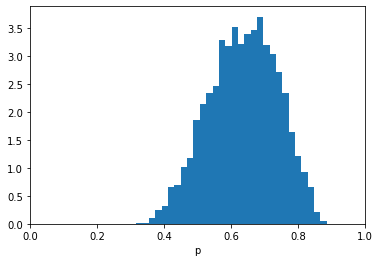

In [128]:
plt.xlim((0, 1))
plt.xlabel('p')
_ = plt.hist(chain['p'], bins=30, density=True)

## Checking

In [97]:
def count_switches(tosses):
    count = 0
    for i in range(1, len(tosses)):
        if tosses[i-1] != tosses[i]:
            count += 1
    return count

Numpyro provides a facility for predictive samples.

In [138]:
predictive = Predictive(globetoss, chain)
predicted_tosses = predictive(random.PRNGKey(1), len(tosses))['toss']

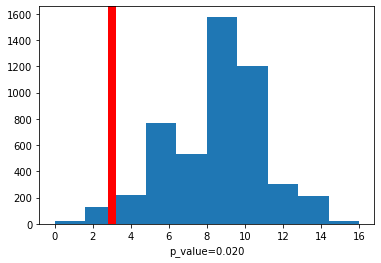

In [99]:
switches = count_switches(tosses)
predicted_switches = numpy.array([count_switches(tosses) for tosses in predicted_tosses])
p_value = len(predicted_switches[switches > predicted_switches])/len(predicted_switches)
plt.hist(predicted_switches)
plt.axvline(count_switches(tosses), color="red", lw=8)
plt.xlabel(f"p_value={p_value:.3f}")
_ = _

## Accounting for dependendies

### Model

In [157]:
def globetoss_walk(N, tosses=None):
    if tosses is None:
        tosses = [None] * N
    p = numpyro.sample('p', dist.Beta(1, 1))
    q = numpyro.sample('q', dist.Beta(1, 1))
    y0 = numpyro.sample('y0', dist.Bernoulli(p))
    # observations are not independent anymore, 
    # so we cannot use numpyro.plate
    yprev = y0
    # numpyro uses JAX for automatic differentiation and JAX
    # cannot differentiate if/else on parameters, at least
    # not without extra effort (https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError)
    #
    # a simple workaround is to use an expression with indicator
    # variables
    for i in range(N):
        θ = yprev*q + (1-q)*p # θ = q + (1-q)*p if yprev else (1-q)*p
        yprev = numpyro.sample(f"toss{i}", dist.Bernoulli(θ), obs=tosses[i])

### Inference

In [158]:
kernel_walk = DiscreteHMCGibbs(HMC(globetoss_walk, trajectory_length=10, step_size=0.1), modified=True)
mcmc_walk = MCMC(kernel_walk, num_warmup=500, num_samples=5000)
mcmc_walk.run(random.PRNGKey(0), N, tosses=tosses)

sample: 100%|██████████| 5500/5500 [00:41<00:00, 134.05it/s, 15 steps of size 6.76e-01. acc. prob=0.95]


In [161]:
chain_walk = mcmc_walk.get_samples()

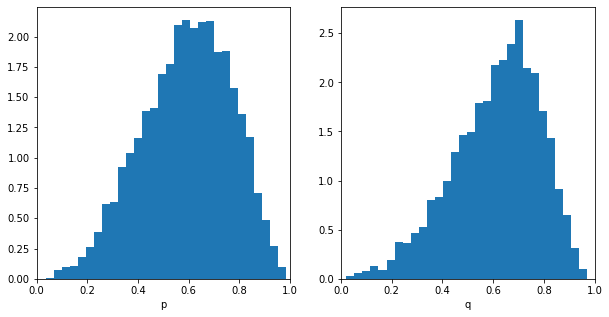

In [162]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, v in enumerate(['p', 'q']):
    ax[i].set_xlabel(v)
    ax[i].set_xlim((0, 1))
    ax[i].hist(chain_walk[v], bins=30, density=True)
_ = _

### Checking

In [174]:
predictive_walk = Predictive(globetoss_walk, chain_walk)
predicted_samples_walk = predictive_walk(random.PRNGKey(0), len(tosses))
predicted_tosses_walk = [[predicted_samples_walk[f"toss{i}"][j] 
                          for i in range(len(tosses))]
                         for j in range(len(predicted_samples_walk))]

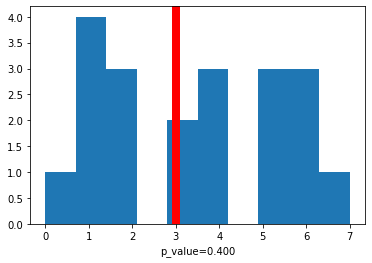

In [179]:
predicted_switches_walk = numpy.array([count_switches(tosses) for tosses in predicted_tosses_walk])
p_value_walk = len(predicted_switches_walk[switches > predicted_switches_walk])/len(predicted_switches_walk)
plt.hist(predicted_switches_walk)
plt.axvline(count_switches(tosses), color="red", lw=8)
plt.xlabel(f"p_value={p_value_walk:.3f}")
_ = _